# Laboratorio 3 - Verbs

Si richiede un’implementazione della teoria sulle valenze di Patrick Hanks.
In particolare, partendo da un corpus a scelta e uno specifico verbo (tendenzialmente non troppo frequente e/o generico ma nemmeno raro), l’idea è di costruire dei possibili cluster semantici, con relativa frequenza.
Ad es. Dato il verbo "to see" con valenza = 2, e usando un parser sintattico (ad es. Spacy), si possono collezionare eventuali fillers per i ruoli di subj e obj del verbo, per poi convertirli in semantic types.
Un cluster frequente su "to see" potrebbe unire subj = noun.person con obj = noun.artifact.
Si richiede di partire da un corpus di almeno alcune centinaia d'istanze del verbo.

## Import delle librerie

In [1]:
base_folder = './data'
!pip install datasets
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
from datasets import load_dataset
import spacy
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt
from nltk import tokenize
import string
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /Users/mario/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mario/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Dati utilizzati

Per questa esercitazione viene utilizzato il database IMDB.

L'obiettivo è estrarre un numero elevato di frasi contenenti il verbo preso in esame. Per questo motivo non è discriminante la scelta del dataset, basta che sia sufficientemente ricco da permettere un'ampia estrazione di esempi.

In [2]:
dataset = pd.DataFrame(load_dataset('imdb', split='unsupervised'))
dataset = dataset.drop(columns=['label'])
nlp = spacy.load('en_core_web_sm')

Found cached dataset imdb (/Users/mario/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


In [3]:
selected_phrases = []
for txt in dataset['text']:
    for s in tokenize.sent_tokenize(txt):
        if 'write' in s.lower():
            selected_phrases.append(s)

## Estrazione del soggetto e dell'oggetto del verbo

I due metodi sottostanti servono per ricavare, a partire dal testo, il soggetto e l'oggetto relativo al verbo.

In [4]:
def get_subject_phrase(text):
    for token in text:
        if 'subj' in token.dep_:
            return token

In [5]:
def get_object_phrase(text):
    for token in text:
        if 'dobj' in token.dep_:
            return token

Anche in questo caso, le frasi sono filtrate per conservare soltanto le parole *content*.

In [6]:
stop = stopwords.words('english')
stop.extend(['\'s', 'i', 'me', 'br'])

def remove_stopwords(phrase):
    for p in string.punctuation:
        stop.append(p)
    return {t for t in phrase if t.lemma_.lower() not in stop}

In [7]:
def filter_elements(phrase):
    if phrase is None:
        return []
    return phrase if phrase.lemma_.lower() not in stop and len(wn.synsets(phrase.lemma_)) > 0 else []

In [8]:
tuples = []
for i, sentence in enumerate(selected_phrases):
    doc = nlp(sentence)
    subj = filter_elements(get_subject_phrase(doc))
    obj = filter_elements(get_object_phrase(doc))

    if len(subj) > 0 and len(obj) > 0:
        tuples.append((subj, obj))

Per gestire i dati ottenuti viene utilizzato un DataFrame della libreria *pandas* con due colonne, la prima per i soggetti e la seconda per gli oggetti. Si è scelto di non riportare il verbo in quanto la colonna conterrebbe sempre lo stesso valore, rendendola non significativa.

In [9]:
phrases = pd.DataFrame(tuples, columns=['subj', 'obj'])

## Lettura dei tipi semantici

Dal file fornito si estraggono i tipi semantici relativi ai synset di WordNet. In questo modo si salvano tutti i possibili tipi semantici e un dizionario che associa ad ogni senso il tipo semantico da restituire.

In [10]:
sem_types = {}
sem_set = set()
with open(f'{base_folder}/csi_inventory_semantictypes.txt') as f:
    for line in f:
        parts = line.strip().split('\t')
        pos, offset = parts[0][-1], int(parts[0][3:-1])
        sem_types[wn.synset_from_pos_and_offset(pos, offset)] = parts[1]
        sem_set.add(parts[1])

## Clustering

Successivamente viene effettuato il conteggio per ogni coppia di tipi semantici a partire dal dataset.

In [11]:
counter = {f'{x}-{y}': 0 for x in sem_set for y in sem_set}
for i, row in phrases.iterrows():
    subj_type = None
    for synset in wn.synsets(row['subj'].text):
        if synset in sem_types:
            subj_type = sem_types[synset]
    obj_type = None
    for synset in wn.synsets(row['obj'].text):
        if synset in sem_types:
            obj_type = sem_types[synset]
    if subj_type is not None and obj_type is not None:
        counter[f'{subj_type}-{obj_type}'] += 1

## Plotting

Infine, vengono visualizzati i dieci cluster più frequenti. Per il termine *write* si può vedere che quasi sempre il soggetto è *language and linguistics*, tipo semantico ragionevole per il verbo scelto.

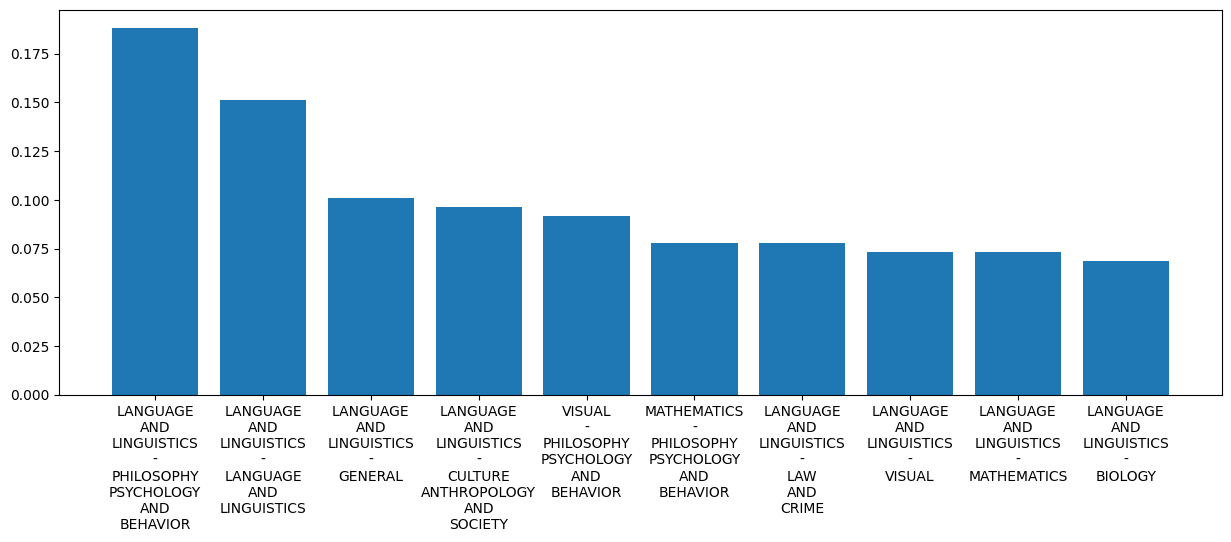

In [13]:
tops = sorted(counter.items(), key=lambda x: x[1], reverse=True)[:10]
tot = sum([x[1] for x in tops])

plt.subplots(figsize=(15, 5))
labels = [x[0].replace('-', '-\n').split('_') for x in tops]
labels = ['\n'.join(x[:-1]) for x in labels]
plt.bar(labels, [x[1]/tot for x in tops])
plt.show()